## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel, SignalKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#Fix root
import sys
sys.path.append("/usr/local/Cellar/root/6.12.04_1/lib/root/")
sys.path.append("/Library/Python/2.7/site-packages/")

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt



Welcome to JupyROOT 6.12/04


/usr/local/Cellar/python/2.7.14_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


## Inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("noMean_outputs/xvalO.npy")
yvalO = np.load("noMean_outputs/yvalO.npy")
xerrO = np.load("noMean_outputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("noMean_outputs/xval.npy")
yval = np.load("noMean_outputs/yval.npy")
xerr = np.load("noMean_outputs/xerr.npy")

#10000 toys - created from smoothed data with Poisson noise
toyList = np.load("noMean_outputs/toyList.npy")
fixedHyperparams = np.load("noMean_outputs/fixedHyperparams.npy")

#injected gaussian signals 
sigToys = np.load("noMean_outputs/signalToys.npy")
sigToysO = np.load("noMean_outputs/signalToysO.npy")
standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]


### Calculate z values and chi squared 

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2


### poisson likelihood

In [5]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### remove zero count bins to use for GP fits. Add back in zero bins for final prediction

In [6]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xvalO):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                continue
            else:
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

## signal+background and background only plotted together

In [7]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 3e5):
    #f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    #f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="Toy data with injected signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="Gaussian Process background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Gaussian Process signal-plus-background")
    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=25)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=25)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("background-only fit residuals",(2020,-3.5), fontsize=25)

    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    #ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=25)
    ax3.tick_params(axis='x', labelsize=25)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("signal+background fit residuals",(2020,-3.5), fontsize=25)
    
    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)

    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    


### signal only component of signal+background fit

In [8]:
def makePrettyPlots_signalOnly(xs, dM_GP, GPs, data, sig, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
   # f.suptitle(title, fontsize=35, y=1.01)
    dataMinusGPbPlot = ax1.errorbar(xs, dM_GP, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Toy data - Gaussian Process background")
    dataPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")
    sigPlot = ax1.plot(xs, sig, linewidth=3.0, c='red',label="Injected signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
   # ax1.set_ylim([-3.5*max(GPs), 3.5*max(GPs)])
    ax1.set_ylim([-50, 75])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

    plt.show()

In [9]:
def makePrettyPlots_signalOnly2(xs, data, GPs, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, data, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Injected Signal")
    sigPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
    #ax1.set_ylim([-3, 1.5*max(GPs)])
    ax1.set_ylim([-0.1, 40])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Mean function for GP

In [10]:
# def model_gp(params, t, xerr): 
#     p0, p1, p2 = params
#     sqrts = 13000.
#     return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

### piecewise linear function for signal

In [11]:
def peak(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    slope=0.5
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center: 
            output[i]=(slope*c-slope*center+amp)
        if c > center and c < center+width:
            output[i]=(-slope*c+slope*center+amp)
    output = [s if s > 0 else 0 for s in output]
    return output

### right triangle function for signal

In [12]:
def triangle(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    offset=10.
    slope1 = amp/(2.*width-offset)
    y1 = amp*(-center+width)/(2*width-offset)
    slope2 = -amp/offset
    y2 = amp*(center+width)/offset
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width-offset: 
            output[i]=slope1*c+y1
        if c > center+width-offset and c < center+width:
            output[i]=slope2*c+y2
    output = [s if s > 0 else 0 for s in output]
    return output

### square signal function

In [13]:
def square(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width: output[i]=amp
    return output

### Gaussian signal function

In [14]:
def gaus(x, amp, center, width, xerr):
    return amp*(np.exp(-(x-center)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xerr

### Smearing functions - use Gaussian kernel to smooth out signals

In [15]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smearO(s, signal_shape):
    smeared_counts=np.zeros(len(xvalO))
    for xi, x in enumerate(xvalO):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [16]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smear(s, signal_shape):
    smeared_counts=np.zeros(len(xval))
    for xi, x in enumerate(xval):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

## OLD KERNEL

### Fit signal GP hyperparameters by minimizing george likelihood with minuit. Keep hyperparameters for background GP fixed

In [17]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
#        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp
        Amp, decay, length, power, sub = fixedHyperparams #best_fit_gp
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            #return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian signals

parameters (400, 3500, 250)
(1069.7412800829675, 1049.7888238110181, 100.0003814696053)
(99999.98735442843, 1706.0624986087805, 143.06526882470848)
(99998.44993526196, 1705.7461305003822, 143.15285478572088)
(99999.99503333446, 1977.318137909153, 308.9521880790561)
(40280.11738561114, 2450.967361438713, 441.9424547023966)
(40504.07922691236, 2449.9307204286315, 442.3254865291337)
(40553.38113720562, 2450.7964841171843, 441.97910996585335)
(40677.20033734415, 2450.2582905242366, 442.1915706133182)
(667.4081163588583, 3572.9658307562677, 188.31920763970027)
(667.520619819027, 3572.953023525571, 188.3944703330111)
A, mass, tau 667.520619819 3572.95302353 188.394470333


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 92.63243019315752


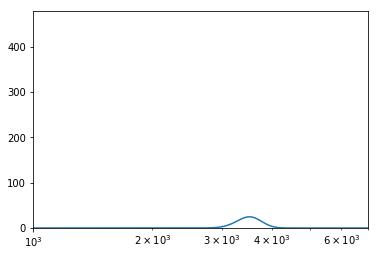

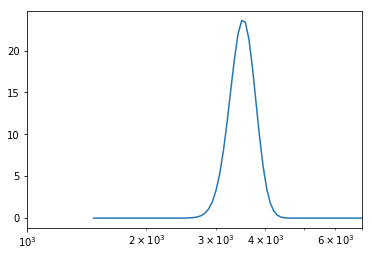

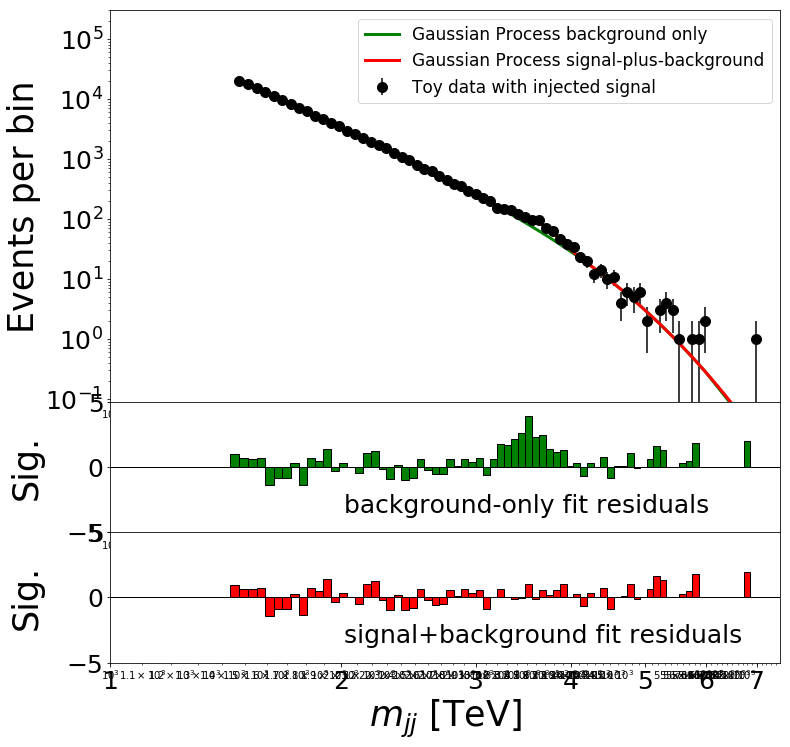

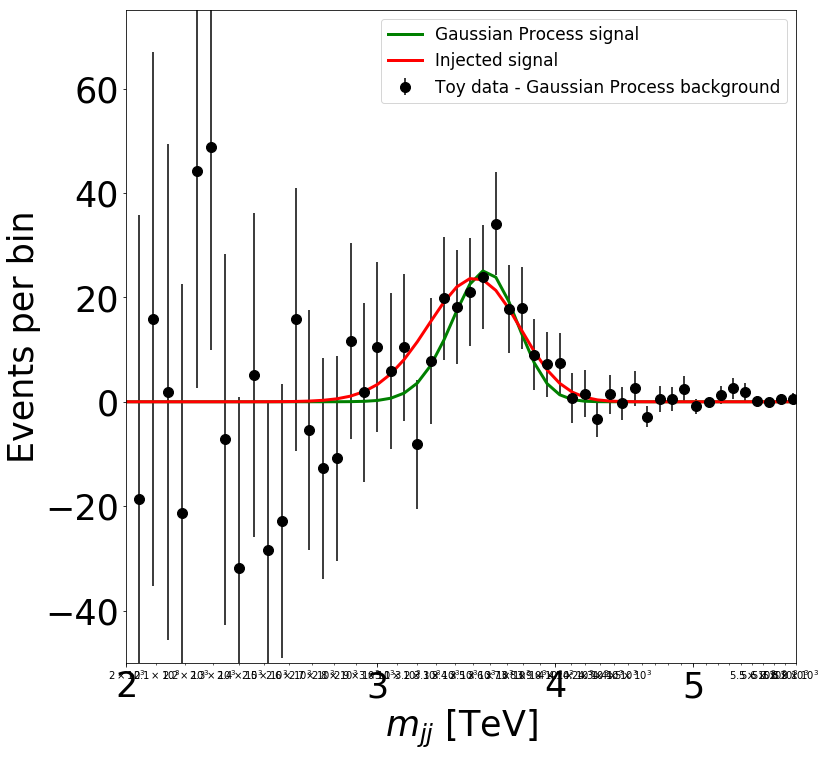

In [18]:
aa={}
mm={}
ww={}
#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(400, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        
        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGPp = gp.predict( ydata, xvalO)[0]
        #meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)
        meanGP = meanGPp

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO[10:]), label)
        

        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

### Peak signals

parameters (60, 3500, 250)
(99999.1450094024, 1709.6634075324782, 131.45545443857645)
(99994.74493870637, 1709.9260873048856, 131.38117454511598)
(99999.95406120962, 1709.8701583580562, 131.39542376392708)
(99999.95698880099, 1709.8728455552157, 131.3840002614215)
(99999.9999999031, 1709.8746063228741, 131.36973782500365)
A, mass, tau 99999.9999999 1709.87460632 131.369737825
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 105.74477374956578


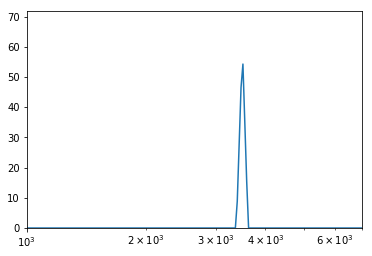

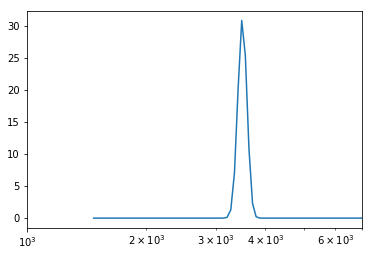

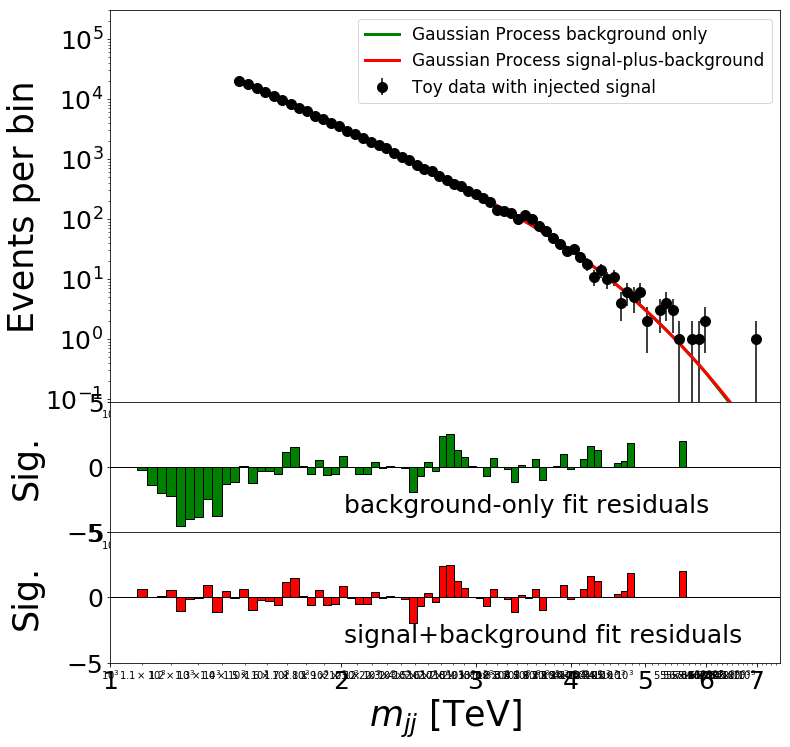

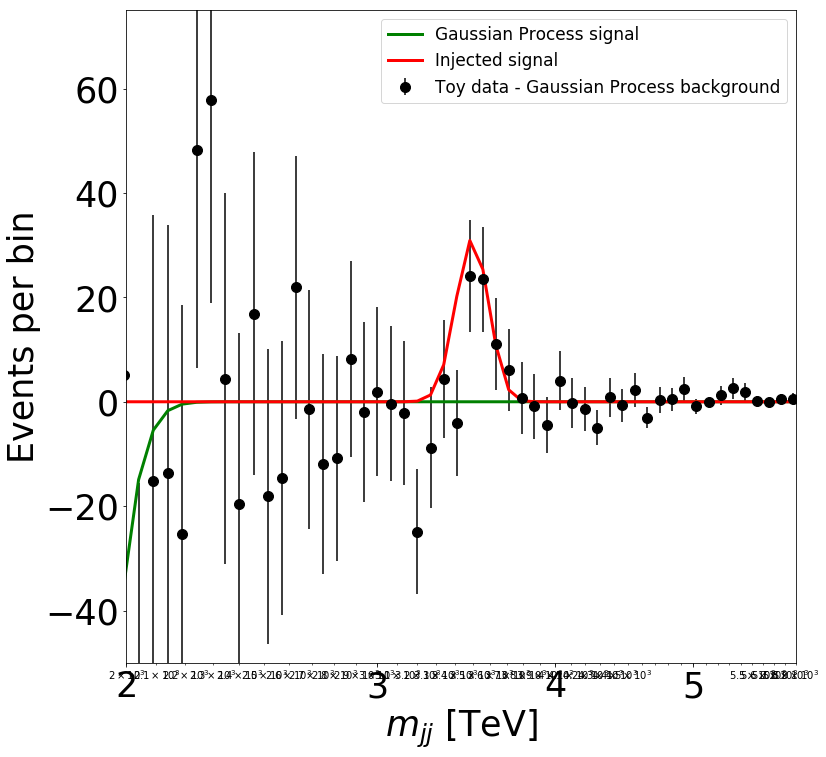

In [19]:
aa={}
mm={}
ww={}
#standardParamSets = [(200,2000,300), (100 ,2500, 250), (75, 3000, 250), (60, 3500, 250), (55, 4000, 250), 
#                     (45, 4500, 250), (40, 5000, 250), (25,5500, 250), (15, 6000,250)]
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGPp = gp.predict( ydata, xvalO)[0]
        #meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)
        meanGP = meanGPp

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### square signals

parameters (20, 3500, 250)
(849.4394683366278, 1000.0005307429975, 141.57673519647636)
(99997.47340627262, 1707.4066107145277, 138.47617653618474)
(26135.49057695572, 2478.1463678908553, 419.5192910685084)
(26274.65504808278, 2477.4579391396414, 419.836862999466)
(26268.27880471903, 2477.6944612594325, 419.70461238927504)
(696.9382181067124, 3543.6863735457273, 156.62662014615788)
A, mass, tau 696.938218107 3543.68637355 156.626620146


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 91.49394044497342


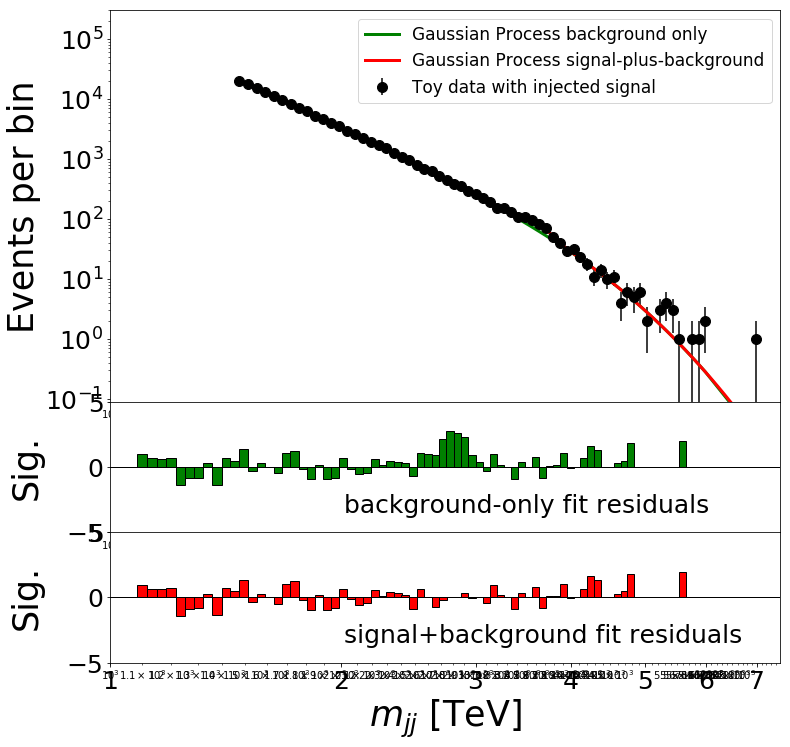

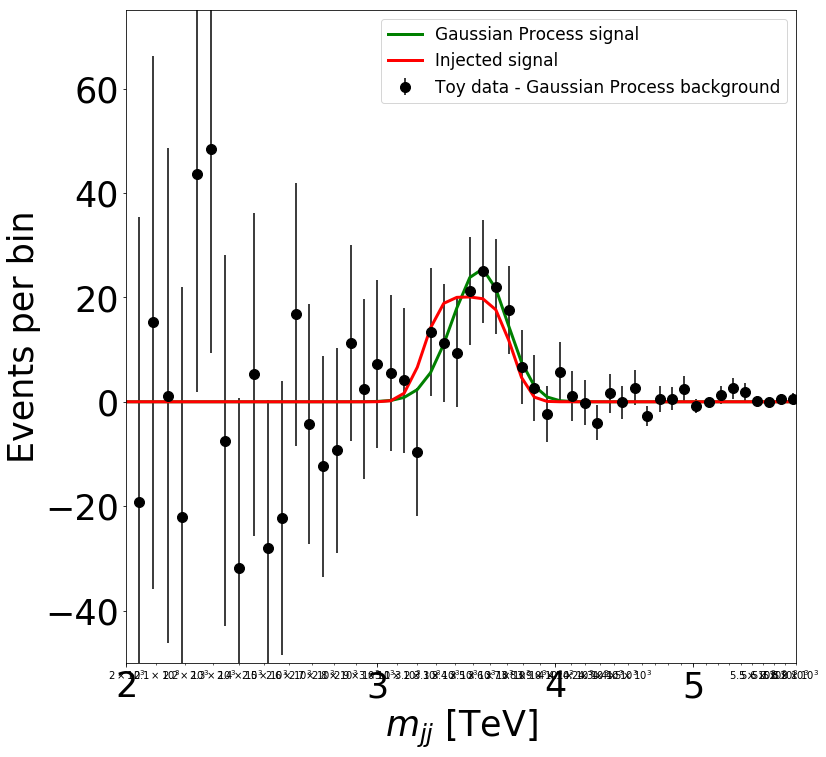

In [20]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGPp = gp.predict( ydata, xvalO)[0]
        #meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)
        meanGP = meanGPp

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### Right Triangle

parameters (40, 3520, 250)
(99445.20955980262, 1253.0211678002474, 100.00001293402643)
(31627.332130956784, 2465.8885568200185, 461.6078294308056)
(31543.575844498733, 2464.407233206429, 462.2947380340811)
(506.2284753037999, 3509.2029974382485, 422.6643666534604)
(1258.7785181220183, 3636.3646232320953, 117.61770987123069)
A, mass, tau 1258.77851812 3636.36462323 117.617709871


NameError: name 'ydat' is not defined

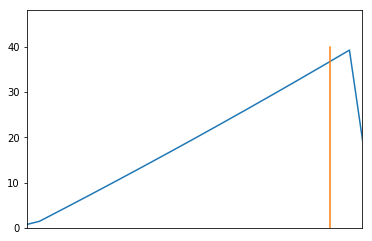

In [21]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGPp = gp.predict( ydata, xvalO)[0]
        #meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)
        meanGP = meanGPp

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydat))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



## NEW SIGNAL KERNEL

In [23]:
class logLike_gp_fitgpsigNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams 
        Amp, decay, length, power, sub = fixedHyperparams 
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            #return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L =1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (10, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian Signal

parameters (300, 3500, 250)
(2825.1511885649156, 1000.0057220440796, 100.0003814696053, 10.009527203392466)
(99999.9808245439, 1967.3931666806106, 315.2223414043064, 9999.757048328314)
(99996.56520467436, 1708.3781002822714, 138.06413127579944, 9930.784742856056)
(99998.9483451259, 1708.4388924756045, 138.1041415807444, 9954.894205986264)
(99999.36999544557, 1708.507388343913, 137.84442562477614, 9982.837565104091)
(99999.97065142382, 1708.4056658162554, 138.0243492858139, 9981.86193979358)
(99999.40368400219, 1708.4416720397548, 137.9686886622966, 9991.795669237943)
(437.81926914912896, 3624.2741239558645, 190.14765782815127, 9991.474459375788)
(434.35301375420534, 3624.362048321518, 190.21162352912495, 9998.568438357219)
A, mass, tau, L 434.353013754 3624.36204832 190.211623529 9998.56843836
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 92.57641785442686


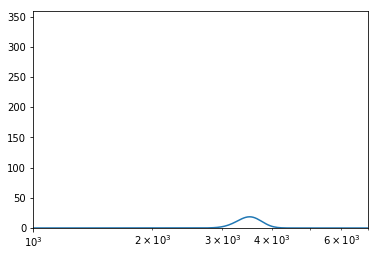

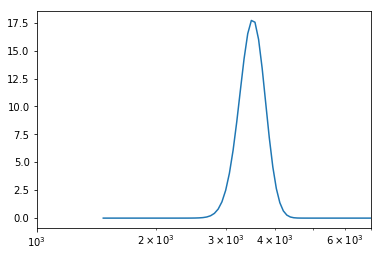

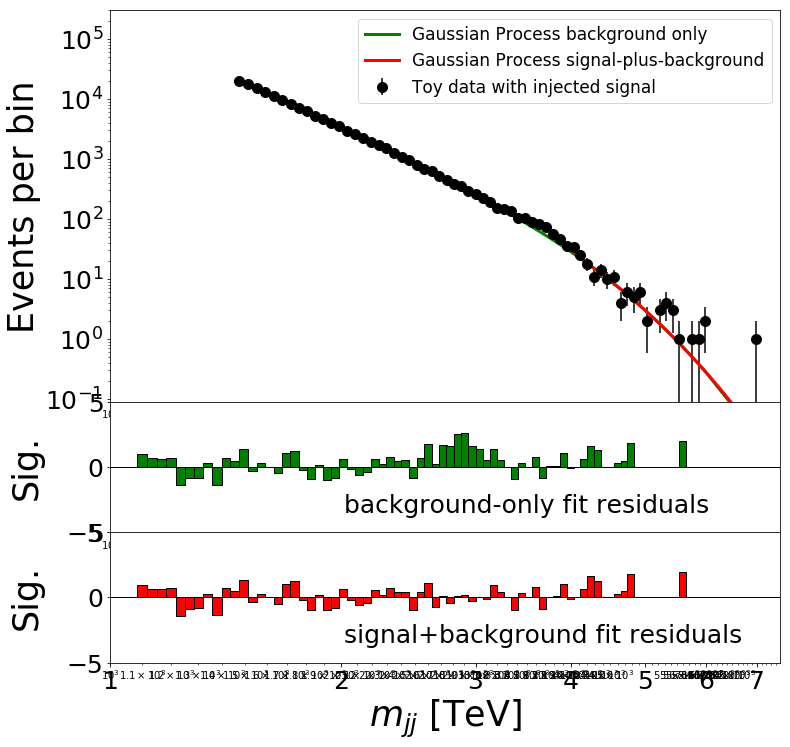

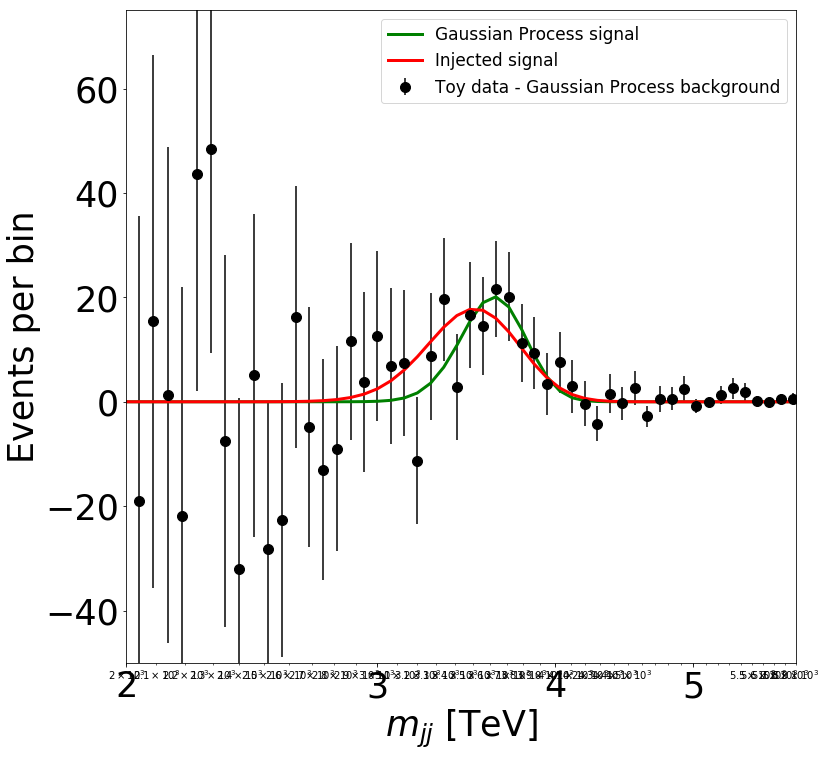

In [24]:
standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGPp = gp.predict( ydata, xvalO)[0]
        #meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)
        meanGP = meanGPp

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

### Peak Signal

parameters (60, 3500, 250)
(99999.9991949516, 1344.325461564825, 100.00000420082777, 10.0280820725072)
(99999.55850019128, 1709.342164926562, 133.89973203609208, 9988.07915760611)
(99999.99225188259, 1709.3871178765226, 133.87230819388049, 9989.02405575972)
(99999.9999163472, 1709.364512056209, 133.75701242432126, 9993.207732829193)
(1277.2476240779877, 3528.612400280045, 100.00000203710047, 9968.903859266025)
(1283.3866288639063, 3528.5728143148876, 100.00005437638544, 9980.306692827864)
(1283.7062130067814, 3528.4987303760186, 100.00000198372088, 9980.424005202452)
A, mass, tau, L 1283.70621301 3528.49873038 100.000001984 9980.4240052
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 89.59652944382339


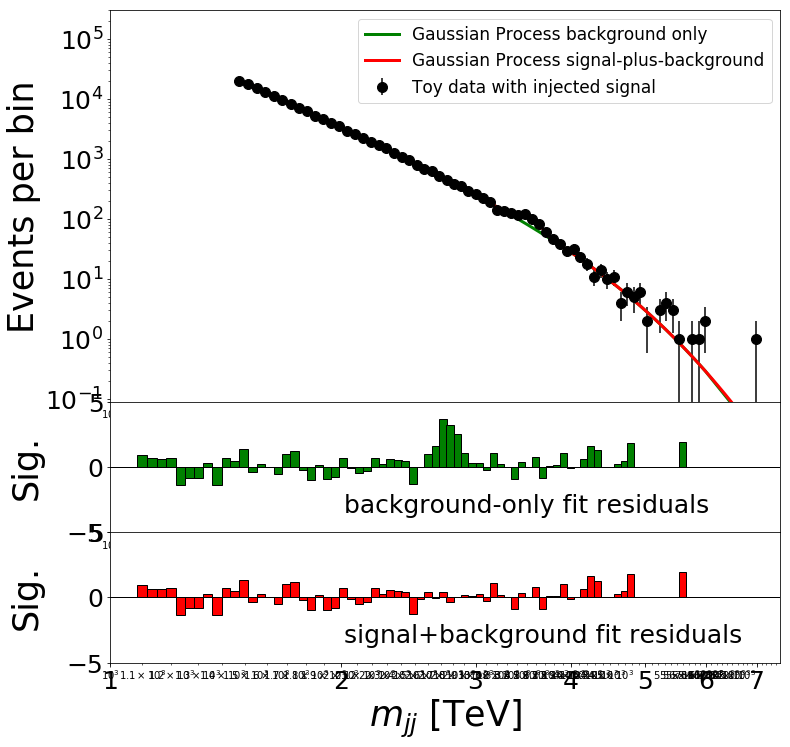

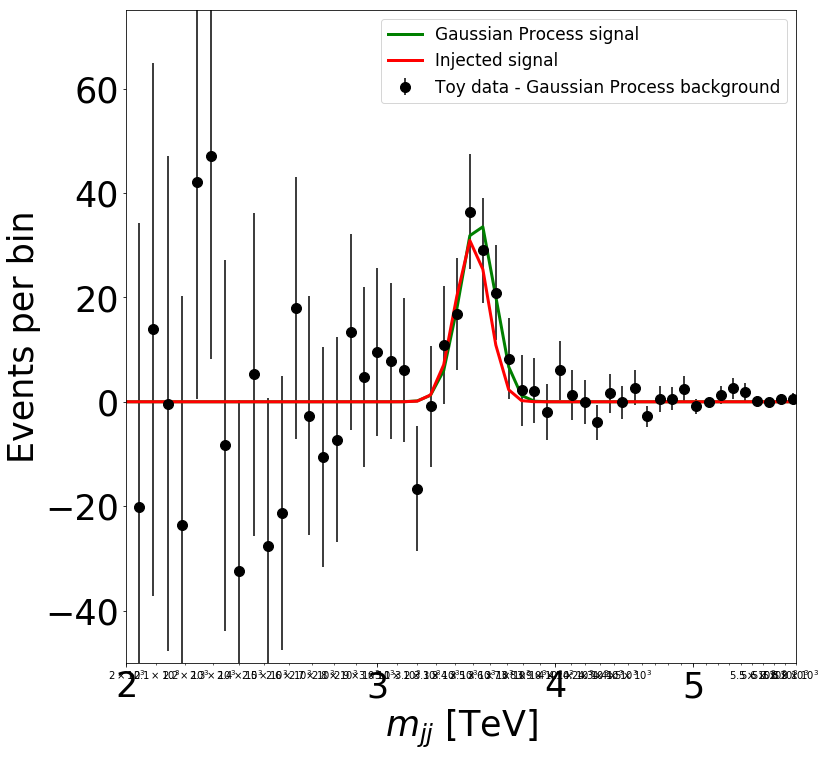

In [25]:
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)

        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO

        
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGPp = gp.predict( ydata, xvalO)[0]
        #meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)
        meanGP = meanGPp

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)




### Square Signal

In [26]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)

        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
  
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp, covGP = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGPp, covGP = gp.predict( ydata, xvalO)
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        print np.sqrt(np.diag(covGP))
        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)





parameters (20, 3500, 250)
(553.9857078839962, 3599.205562160115, 129.9250038782387, 9964.993418654509)
(554.9220994912996, 3599.234454757918, 130.03183307678842, 9971.426195394028)
(553.2126689400558, 3599.300963561736, 129.9605572888768, 9972.87852621447)
(554.7035113336882, 3599.2362428549814, 129.94948041557177, 9982.357610455489)
A, mass, tau, L 554.703511334 3599.23624285 129.949480416 9982.35761046


NameError: name 'model_gp' is not defined

### Right Triangle

parameters (40, 3520, 250)
(99999.89033781676, 1956.6929461249856, 334.30551334725635, 9998.6497678242)
(99999.97498051009, 1709.1737150473793, 139.27422553713106, 9983.398936495274)
(1341.94325473825, 3642.623838520065, 127.10574243667435, 9999.750169287376)
(1324.9039448413835, 3642.7723030079474, 127.09040510638852, 9995.763857452188)
(1327.6867330763466, 3642.765671956061, 127.08161046591792, 9997.835280039355)
A, mass, tau 1327.68673308 3642.76567196 127.081610466 9997.83528004


NameError: name 'model_gp' is not defined

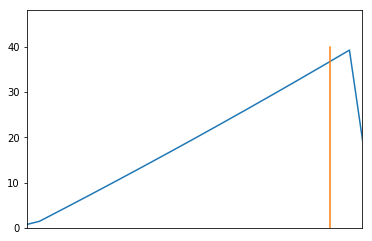

In [27]:
standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        #meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)
        meanGP = meanGPp 

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



## SIGNAL ONLY FIT

In [29]:
class logLike_gp_fitgpsigonlyNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        kernel = A * SignalKernel(m = mass, t = tau, L = L)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonlyNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L = 1.,
                  limit_A = (1, 100), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (100, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [30]:
class logLike_gp_fitgpsigonly:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonly_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 100), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian Signal

parameters (300, 3500, 250)
(99.99990558627267, 1571.648584558235, 100.0003814696053)
(1.0000161447702838, 1000.0000000000014, 100.00000000000007)
(1.0000000421634552, 1000.0000021022863, 100.00000011091417)
(99.99367874541294, 3482.829345104402, 100.00000000059717)
(99.99999629912926, 3482.8274682320684, 100.00000000000784)
(99.99992415219751, 3482.8274371598527, 100.00000000001121)
(99.883447840737, 3482.8282501709164, 100.00000004054377)
(99.68681722707441, 3482.8252635519793, 100.00000000446789)
A, mass, tau 99.6868172271 3482.82526355 100.000000004
[3.61654165e-088 9.36130997e-085 2.28312682e-081 5.21516357e-078
 1.21630482e-074 2.61359914e-071 5.14187522e-068 1.00293416e-064
 1.91436219e-061 3.25223651e-058 4.88444216e-055 6.95614041e-052
 9.26368580e-049 1.13729389e-045 1.18322075e-042 1.03554975e-039
 8.07334053e-037 5.52246693e-034 3.26362820e-031 1.64027171e-028
 6.89934792e-026 2.38933321e-023 6.70024698e-021 1.49585339e-018
 2.61324300e-016 3.51027580e-014 3.56140372e-012 2

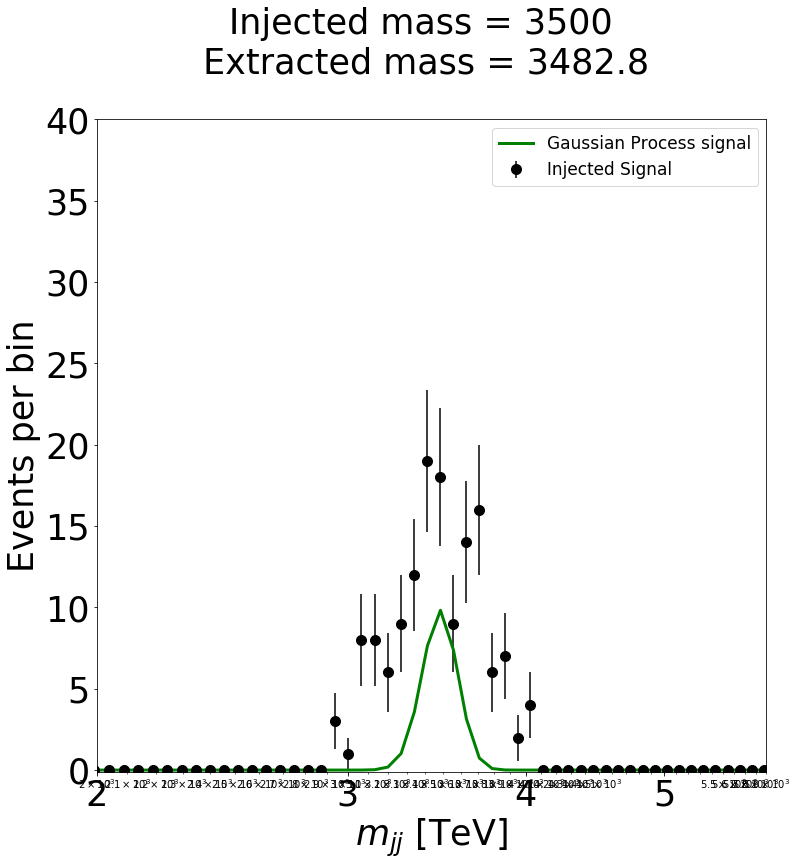

(99.99900041087483, 3458.1376468164817, 100.00000048457034, 317.6141374101352)
(99.99995438469657, 3458.084800537597, 100.00000502774897, 318.5223081375691)
(99.99999997026502, 3458.086368038705, 100.0000000108325, 317.9619434069224)
A, mass, tau 99.9999999703 3458.08636804 100.000000011 317.961943407
[2.98370384e-085 7.00422684e-082 1.54731148e-078 3.19744131e-075
 6.72960549e-072 1.30335124e-068 2.30824599e-065 4.04293266e-062
 6.91252866e-059 1.05061972e-055 1.40990354e-052 1.78967223e-049
 2.11900177e-046 2.30704430e-043 2.12558164e-040 1.64486296e-037
 1.13029037e-034 6.78898915e-032 3.50580344e-029 1.52936965e-026
 5.53086561e-024 1.62458513e-021 3.78979560e-019 6.84847681e-017
 9.31949033e-015 9.23429507e-013 6.37672973e-011 2.86834267e-009
 7.35100064e-008 1.11224169e-006 5.21952169e-005 1.37769956e-003
 1.88098354e-002 1.44563029e-001 6.42559573e-001 1.63451441e+000
 2.44143572e+000 2.51481860e+000 1.93669283e+000 8.99403708e-001
 2.18811738e-001 2.68310321e-002 1.60575176e-00

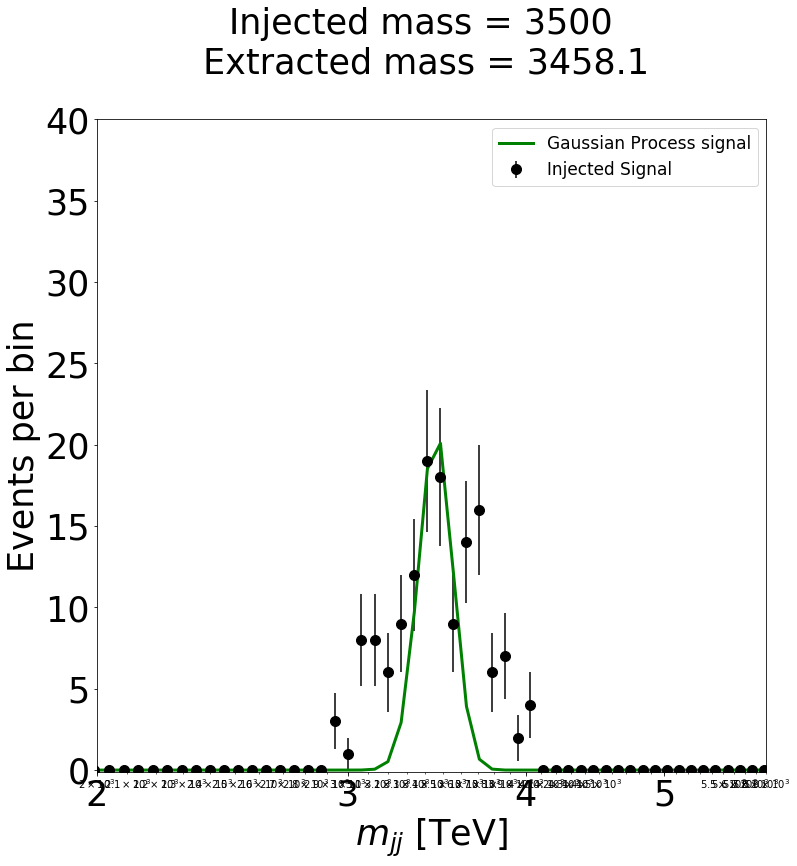

In [31]:

standardParamSets=[(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        #plt.figure()
        #plt.plot(xvalO, smeared_countsO)
        #plt.xlim([1000,7000])
        #plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)
        ####################################################################################

        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
            
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

### Peak Signal

parameters (60, 3500, 250)
(1.0000005482717824, 1000.0000000000014, 100.00000000002215)
(1.0000000094149148, 1000.0000007436641, 100.00000000711499)
(1.0000210206986953, 6486.919216379597, 100.00000297019189)
(1.000000000008205, 6487.002090809337, 100.00000000043987)
(1.0000000012904833, 6486.999732322369, 100.00000000859141)
A, mass, tau 1.00000000129 6486.99973232 100.000000009
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000

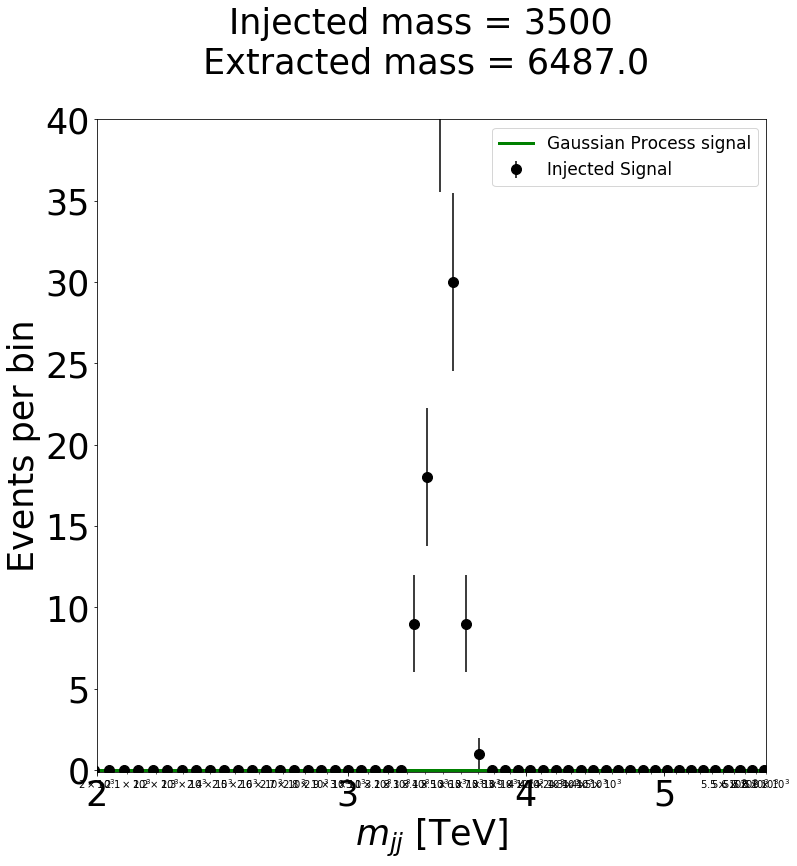

(1.000000176826625, 1000.0000003233727, 100.00000001901228, 3120.543527052335)
(1.0000037739441052, 1000.0001332444505, 100.00000440735712, 7007.119681002177)
(1.0000000130141506, 6487.019844183271, 100.00000927526347, 9999.908808561671)
(1.000000373887712, 6487.003888492214, 100.00000046784525, 9999.998197653706)
(1.0000000130554503, 6486.999773232699, 100.0000000986627, 9999.994858973652)
(1.0000000130554503, 6486.999773232699, 100.0000000986627, 9999.994858973652)
A, mass, tau 1.00000001306 6486.99977323 100.000000099 9999.99485897
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.0

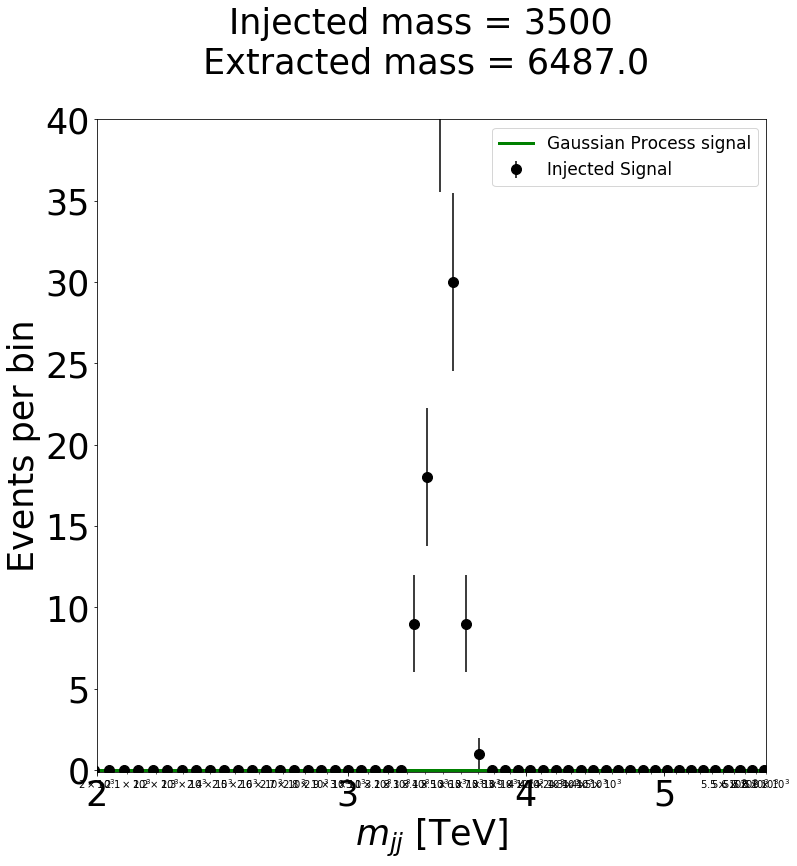

In [32]:
standardParamSets = [(60, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        #plt.figure()
        #plt.plot(xvalO, smeared_countsO)
        #plt.xlim([1000,7000])
        #plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        
        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)

        #########################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

### Square Signal

parameters (20, 3500, 250)
(1.0, 1000.0000000000014, 100.00000000000007)
(1.0000000001088953, 6486.999677729956, 100.00000119376624)
(1.000000001762116, 6486.999933362784, 100.00000000480871)
A, mass, tau 1.00000000176 6486.99993336 100.000000005
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 1.23687088e-159 1.64768268e-150 1.72131923e-141
 1.20278188e-132 6.17745150e-124 2.246

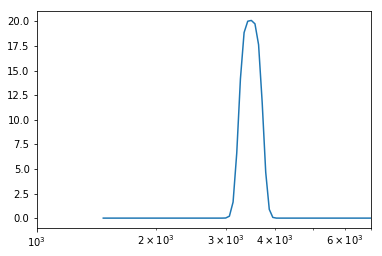

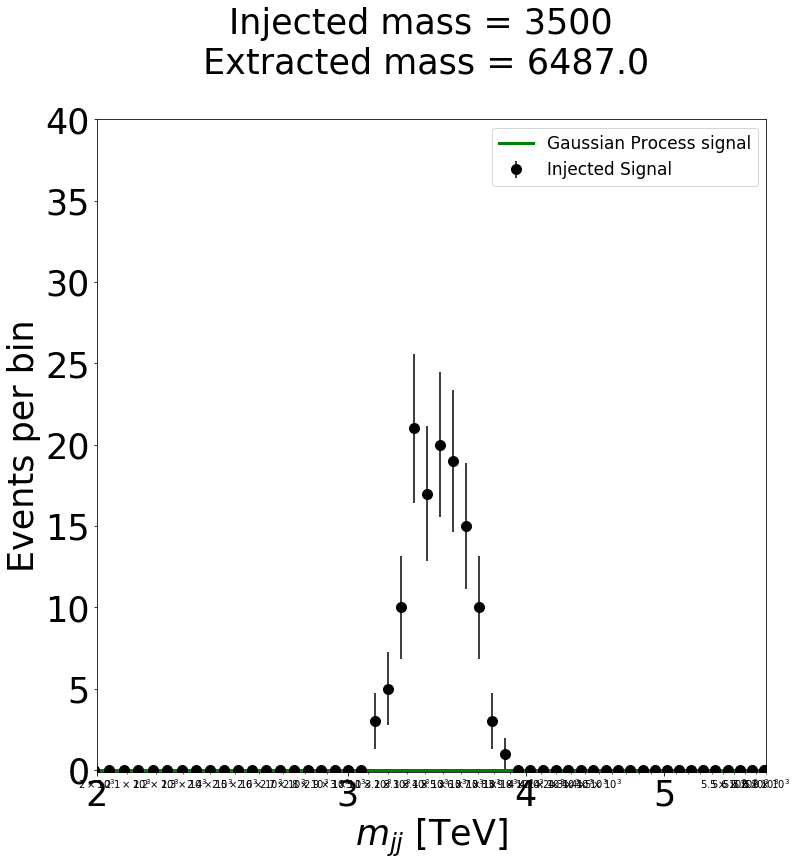

(99.99999227099569, 3463.6448110891884, 100.00000001217452, 131.23416595645972)
(99.99999833011553, 3463.561518808453, 100.0000000011099, 131.21662309314308)
(99.99999999983203, 3463.5932816133814, 100.00000000002385, 131.2165153126683)
(99.99999999983203, 3463.5932816133814, 100.00000000002385, 131.2165153126683)
A, mass, tau 99.9999999998 3463.59328161 100.0 131.216515313
[9.98755297e-086 2.39613064e-082 5.41121176e-079 1.14341908e-075
 2.46216812e-072 4.88016394e-069 8.84747831e-066 1.58722211e-062
 2.78113108e-059 4.33305223e-056 5.96243438e-053 7.76494855e-050
 9.43800987e-047 1.05550538e-043 9.99371682e-041 7.95221528e-038
 5.62588819e-035 3.48543012e-032 1.86197622e-029 8.44314415e-027
 3.19798248e-024 9.95375440e-022 2.50364381e-019 4.99937653e-017
 7.74541787e-015 8.92593354e-013 7.04681826e-011 3.35592372e-009
 8.36309919e-008 1.03238034e-006 1.11762800e-006 1.11803345e-006
 9.10428176e-003 1.58831719e-001 9.48544769e-001 2.44648458e+000
 3.27977824e+000 3.22679774e+000 2.815

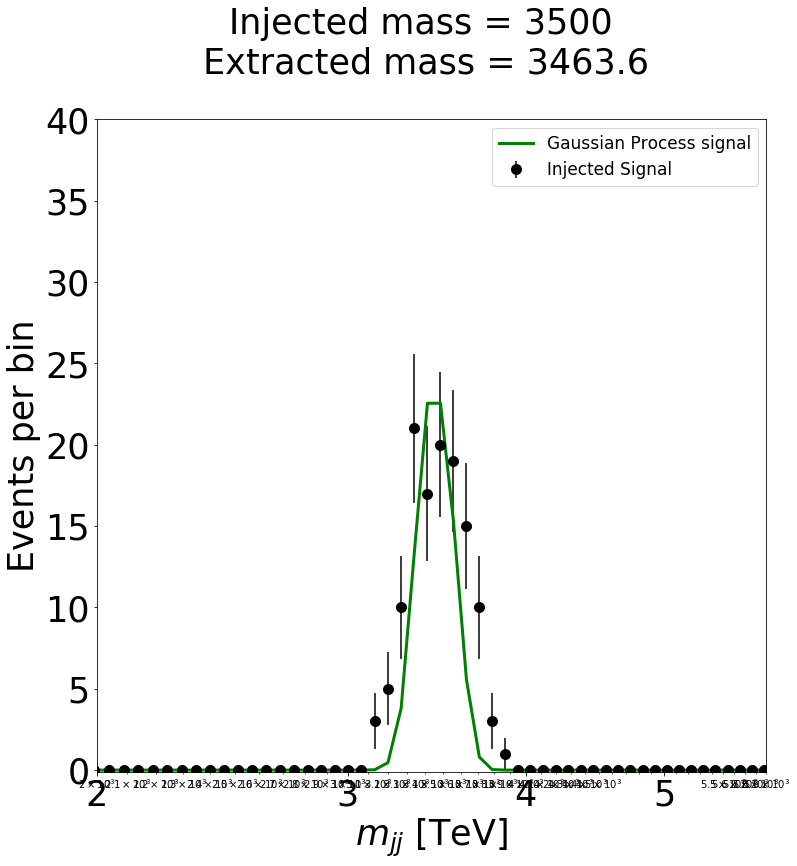

In [33]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)

        ##############################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)
        

### Right Triangle

parameters (40, 3520, 250)
(1.0000014772809591, 1000.0000074335611, 100.00001387579451)
(1.0000000092202055, 1000.0000000000014, 100.00000026107716)
(1.0000000000089468, 1000.0000000000014, 100.00000000000007)
(1.000000139718889, 6486.992139784258, 100.00000208005531)
(1.00000004334939, 6487.002032438734, 100.00000004472895)
A, mass, tau 1.00000004335 6487.00203244 100.000000045
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 

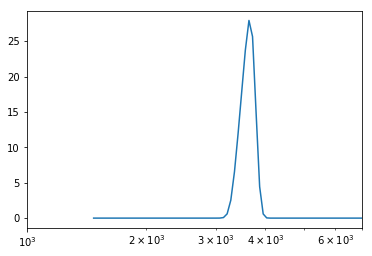

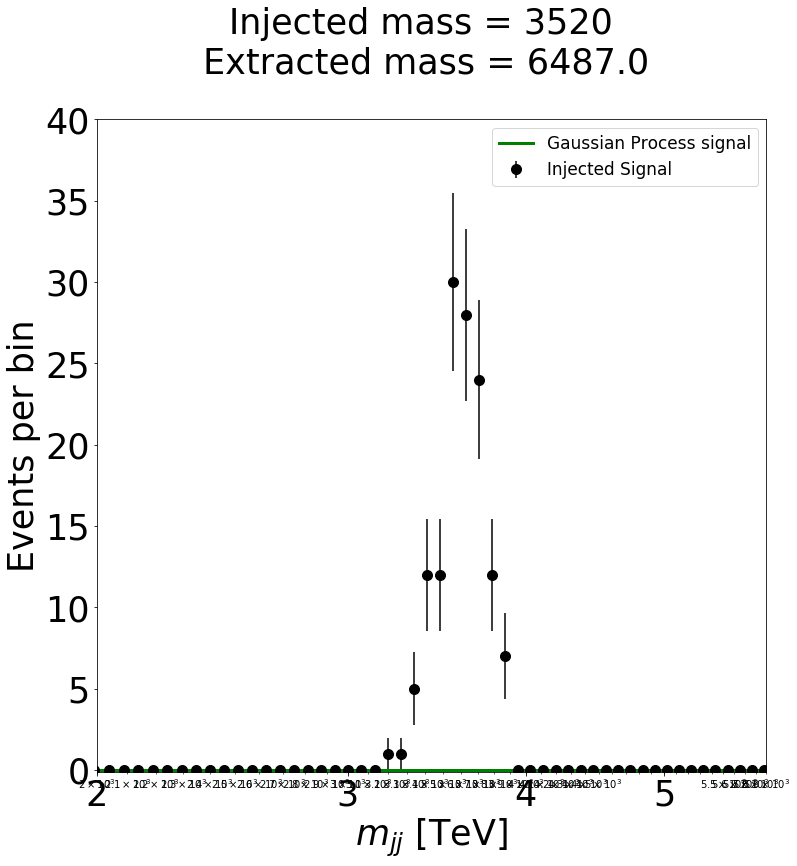

(1.000000461867836, 1000.000009658096, 100.00008864244181, 6667.100972813572)
(1.0000034800807187, 1000.0000027670106, 100.00000360840708, 9800.244753308836)
(99.99997851914603, 3578.7534495696987, 100.00000078765193, 140.29496101861662)
(99.99998417114155, 3578.7422508997956, 100.0000002683584, 140.25466571809227)
(99.99999944110967, 3578.7474592868084, 100.00000008889971, 140.2396425436668)
(99.99999980128477, 3578.7285174039353, 100.00000000345659, 140.2903939319763)
(99.99999980128477, 3578.7285174039353, 100.00000000345659, 140.2903939319763)
A, mass, tau 99.9999998013 3578.7285174 100.000000003 140.290393932
[5.76265618e-096 2.17863445e-092 7.79792031e-089 2.62663798e-085
 9.12059700e-082 2.93191169e-078 8.67055742e-075 2.56670830e-071
 7.50709357e-068 1.96361338e-064 4.56244340e-061 1.01490301e-057
 2.13146753e-054 4.16649958e-051 6.93506697e-048 9.75718652e-045
 1.23464099e-041 1.38394666e-038 1.35316495e-035 1.13604285e-032
 8.05899433e-030 4.75234994e-027 2.29111026e-024 8.87

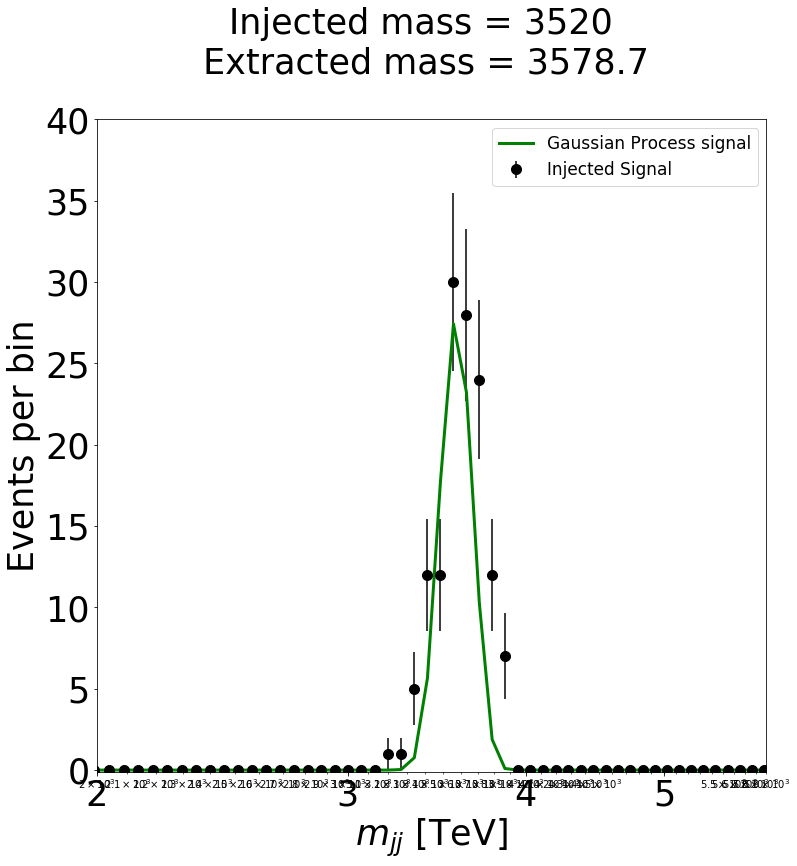

In [34]:
standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        
        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)


        ##############################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

## NO SMEARING OR NOISE ON SIGNAL

parameters (20, 3500, 250)
(23326.155847898262, 2480.650668674082, 422.2799225556422, 9998.119926082498)
(719.419860416501, 3560.8673446630614, 148.26940409775457, 9995.089283741394)
(719.5588775025191, 3560.9027541087953, 148.28746762998577, 9999.18023467004)
A, mass, tau, L 719.558877503 3560.90275411 148.28746763 9999.18023467
chi2 bkg+signal mu=0 nan


/usr/local/Cellar/ipython@5/5.5.0_2/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 97.69453647225127


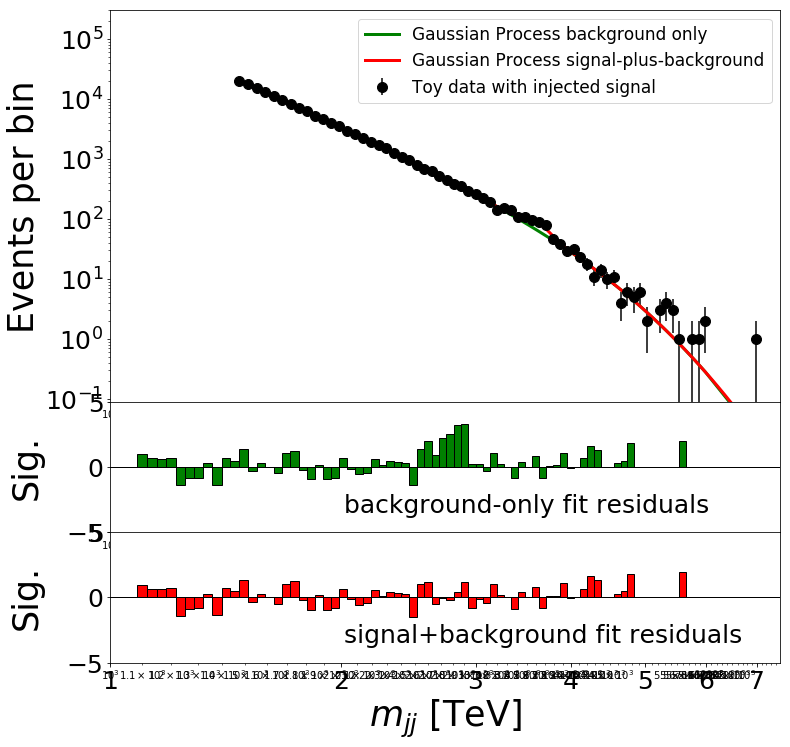

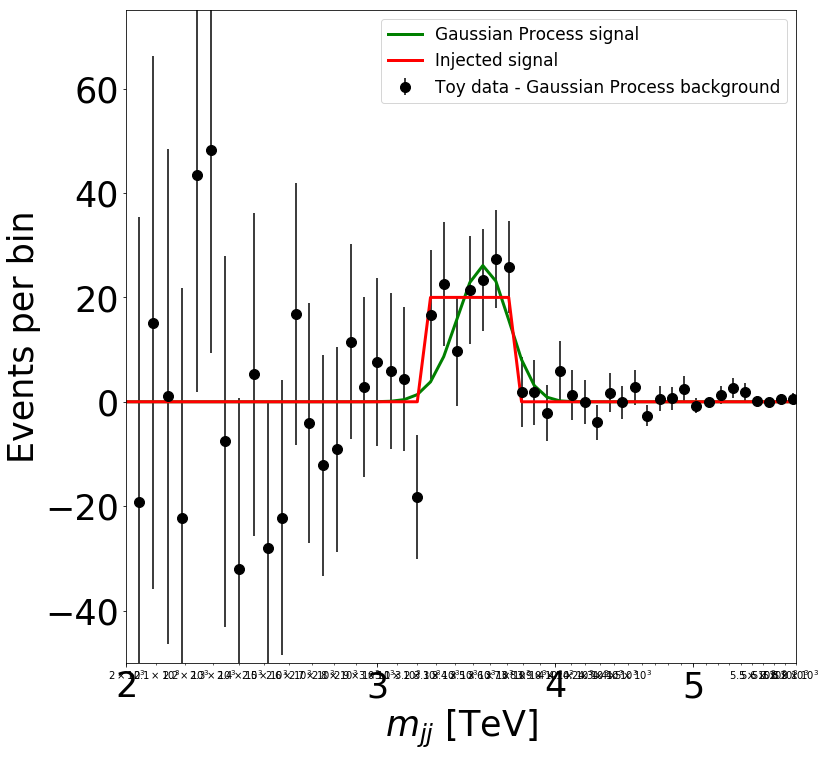

In [36]:


standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(xtoy, n, m, w, xtoyerr)
        ydata = signal+ytoy
        
        signalO = square(xvalO, n, m, w, xerrO)
        ydataO = yvalO+signalO
        
        #Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        Amp, decay, length, power, sub = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        #meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGPp = gp.predict( ydata, xvalO)[0]
        #meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)
        meanGP = meanGPp

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        #mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata))
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        #mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        #makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, signalO, m, label)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, signalO, m, label)
        